# Konduit Serving Model Runtime with YAML Configuration

Konduit supports specifying server configurations as YAML files. This allows you to serve simple server configurations using: 
1. the Konduit Python CLI, and   
2. the `konduit.load` module. 

The YAMLs on this page can be used as boilerplate code for your model serving use cases. 

Some resources on the YAML format are as follows: 
- https://gettaurus.org/docs/YAMLTutorial/
- https://docs.saltstack.com/en/latest/topics/yaml/
- http://jessenoller.com/blog/2009/04/13/yaml-aint-markup-language-completely-different

In [1]:
from PIL import Image 
import numpy as np 
import os
from konduit.load import server_from_file, client_from_file
import matplotlib.pyplot as plt

In [2]:
from urllib.request import urlretrieve 
from zipfile import ZipFile
dl_path = "../data/bert/bert.zip"
if not os.path.isfile(dl_path):
    urlretrieve("https://deeplearning4jblob.blob.core.windows.net/testresources/bert_mrpc_frozen_v1.zip", 
                dl_path)
with ZipFile(dl_path, 'r') as zipObj:
    zipObj.extractall()

A Konduit Serving YAML configuration file has three top-level entities: 
1. `serving`
2. `steps`
2. `client`

The following is a sample YAML file for serving a Python script located at `simple.py` which takes a NumPy array `first` as input and a NumPy array `second` as output:

```yaml
serving:
  http_port: 1337
  input_data_format: NUMPY
  output_data_format: NUMPY
  log_timings: True
  extra_start_args: -Xmx8g
steps:
  python_step:
    type: PYTHON
    python_code_path: ./simple.py
    python_inputs:
      first: NDARRAY
    python_outputs:
      second: NDARRAY
client:
    port: 1337
```


## Serving 

The server configuration takes the following arguments: 

- `http_port`: specify the port number 
- `input_data_format` and `output_data_format`: specify one of the following: JSON, NUMPY, ARROW, IMAGE
- `log_timings`: specify True to log timings 
- `extra_start_args`: Java Virtual Machine (JVM) arguments. In this case, `-Xmx8g` specifies that the maximum memory allocation for the JVM is 8GB. 


Refer to the [Server](https://serving.oss.konduit.ai/server/inference) documentation for details. 


## Client 

Refer to the [Client](https://serving.oss.konduit.ai/client/python-client) documentation for details. 

- `input_names`, `output_names`: names of the first and final nodes of the Konduit Serving pipeline configuration defined in the Server. These arguments are typically inherited from the Server when initialized. 
- `input_data_format`, `output_data_format`, `return_output_data_format`: One of the following: JSON, NUMPY, ARROW, IMAGE. `input_data_format` and `output_data_format` refer to the format of the server's input and output, whereas `return_output_data_format` specifies the data format returned to the client. 
- `port`: specify the same HTTP port as the Server. 

## Running YAML configurations 

A Konduit Serving instance can be started using 

```python
server = server_from_file(konduit_yaml_path)
```

assuming the path of your YAML configuration is specified in `konduit_yaml_path`. 

Note that the file also contains Client configuration. To create a Client object, run the following code: 

```python
client = client_from_file(konduit_yaml_path)
```

Now your data can be passed to `client` for prediction using: 

```python
client.predict(data_input)
```

where `data_input` is a dictionary. 

If the input name is `default`, a NumPy array can be directly passed to the `.predict()` method. 

# PythonStep

Python steps can take any argument that can be passed to `PythonConfig`.  
Specify a Python step as follows: 

```yaml
steps: 
  python_step: 
    type: PYTHON
    python_code: simple.py 
```

- `type`: specify this as PYTHON
- `python_code`: if you want to specify your Python code directly in your YAML file. The following [documentation](http://blogs.perl.org/users/tinita/2018/03/strings-in-yaml---to-quote-or-not-to-quote.html) may be helpful for specifying multi-line Python code, specifically the section on literal block scalars.
- `python_code_path`: specify the path of a Python `.py` script. 
- `python_inputs`: name-value pairs specifying the data types for each of the inputs referenced in the script 
- `python_outputs`: name-value pairs specifying the data types for each of the outputs referenced in the script
- `python_path`: location of the Python modules. Generally, if your script only requires NumPy, setting a custom `python_path` is not necessary. Refer to the [Python modules](https://serving.oss.konduit.ai/python#python-modules-and-the-pythonpath-argument) documentation on setting a custom Python path with additional modules. 

The names referenced in `python_inputs` and `python_outputs` correspond with `inputColumnNames` and `outputColumnNames`.  Modifying `python_inputs` and `python_outputs` does not modify the input and output name of the step. `input_names` and `output_names` are arguments to `PythonStep` which cannot be accessed through the YAML configuration, and default to the name `default`. 

## Example 1: Array operation

```yaml
serving:
  http_port: 1337
  input_data_format: NUMPY
  output_data_format: NUMPY
  log_timings: True
  extra_start_args: -Xmx8g
steps:
  python_step:
    type: PYTHON
    python_code_path: ./simple.py
    python_inputs:
      first: NDARRAY
    python_outputs:
      second: NDARRAY
client:
    port: 1337
```

In [3]:
input_arr = np.array(33)

konduit_yaml_path = "../yaml/simple.yaml"
server = server_from_file(konduit_yaml_path)
client = client_from_file(konduit_yaml_path)
print(client.predict(input_arr))
server.stop()

np.save("../data/simple/input_arr.npy", input_arr)

Starting server....

Server has started successfully.
35


## Example 2: PyTorch and ONNX Runtime

The following is a sample YAML for serving a PyTorch model using a Python script.

```yaml
serving:
  http_port: 1337
  input_data_format: NUMPY
  output_data_format: NUMPY
  log_timings: True
  extra_start_args: -Xmx8g
steps:
  python_step:
    type: PYTHON
    python_path: .
    python_code_path: ../python/pytorch.py
    python_inputs:
      image: NDARRAY
    python_outputs:
      img_out_y: NDARRAY
client:
    port: 1337
```

Note the following: 
- The `python_path` has been left out intentionally. Replace this following the instructions in the [Python modules documentation](https://serving.oss.konduit.ai/python#python-modules-and-the-pythonpath-argument), making sure that ONNX and PyTorch are installed in said Python environment. Refer to the [PyTorch quickstart](https://pytorch.org/).
- The YAML file referenced below shows how to use YAML literal blocks to embed the Python code within your YAML file. 

Refer to the [ONNX Runtime](https://serving.oss.konduit.ai/examples/onnx) page for complete documentation.

In [4]:
im = Image.open("../data/facedetector/1.jpg")
im = np.array(im).astype("int")

konduit_yaml_path = "../yaml/pytorch.yaml"
server = server_from_file(konduit_yaml_path)
client = client_from_file(konduit_yaml_path)
print(client.predict(im))
server.stop()

Starting server..

Server has started successfully.
[[[ 0.00601701  0.00688479  0.02177745  0.03408115]
  [-0.0018133  -0.00657785  0.03698186  0.05206966]
  [-0.01035942 -0.01786287  0.04902049  0.06799769]
  ...
  [ 0.7294515   0.6165271   1.0584102   1.1059598 ]
  [ 0.65046376  0.48442802  1.141786    1.2248938 ]
  [ 0.5633501   0.37209463  1.2047783   1.2747201 ]]]


# ModelStep

## Deeplearning4j
A Deeplearning4j model step can be specified as follows: 

```yaml
steps:
  dl4j_mln_step:
    type: MULTI_LAYER_NETWORK
    model_loading_path: ../data/multilayernetwork/SimpleCNN.zip
    input_names: 
    - image_array
    output_names: 
    - output
    input_data_types:
      image_array: FLOAT
```

Depending on the type of model, specify a `dl4j_mln_step` or a `dl4j_cg_step` for MultiLayerNetwork and ComputationGraph models respectively. 


- `type`: `MULTI_LAYER_NETWORK` or `COMPUTATION_GRAPH`
- `model_loading_path`: location of model weights 
- `input_names` and `output_names`: name of input and output nodes. See [here](https://serving.oss.konduit.ai/examples/dl4j#configuring-modelstep) for details on obtaining the names of input and output nodes. 
- `input_data_types`: map input nodes to data types. List of accepted data types are available [here](https://github.com/KonduitAI/konduit-serving/blob/master/konduit-serving-api/src/main/java/ai/konduit/serving/model/TensorDataType.java).



The following is a sample YAML file for serving a Deeplearning4j model:

```yaml
steps:
  dl4j_mln_step:
    type: MULTI_LAYER_NETWORK
    model_loading_path: ../data/multilayernetwork/SimpleCNN.zip
    input_names: 
    - image_array
    output_names: 
    - output
    input_data_types:
      image_array: FLOAT
```

In [5]:
rand_image = np.random.randint(255, size=(1, 3, 224, 224)) / 255
konduit_yaml_path = "../yaml/deeplearning4j.yaml"
server = server_from_file(konduit_yaml_path)
client = client_from_file(konduit_yaml_path)
print(client.predict({"image_array": rand_image}))
server.stop()

Starting server...

Server has started successfully.
[[4.1334968e-02 3.2425719e-01 2.5129888e-02 3.9935028e-05 6.0923803e-01]]


## Tensorflow Graph ('frozen model')

Konduit Serving supports loading models saved in the TensorFlow Graph format. See the [relevant documentation](https://serving.oss.konduit.ai/examples/tensorflow-model-serving/tf-mnist) on how to save models in the TensorFlow Graph format. 

Declare a TensorFlow step in your YAML file as follows: 

- `type`: set `type` as `TENSORFLOW`
- `model_loading_path`: location of the model weights 
- `input_names`, `output_names`: a list of the input and output nodes 
- `input_data_types`: maps input nodes to the corresponding [data type](https://github.com/KonduitAI/konduit-serving/blob/master/konduit-serving-api/src/main/java/ai/konduit/serving/model/TensorDataType.java)
- `parallel_inference_config`: specify the number of workers to run in parallel 

### Example 1: MNIST classifier
```yaml
steps:
  tensorflow_step:
    type: TENSORFLOW
    model_loading_path: ../data/mnist/mnist_2.0.0.pb
    input_names:
      - input_layer
    output_names:
      - output_layer/Softmax
    input_data_types:
      input_layer: FLOAT
    parallel_inference_config:
      workers: 1
```

We can start a Konduit Serving instance as follows: 

In [6]:
img = np.load("../data/mnist/input_layer.npy")
konduit_yaml_path = "../yaml/tensorflow-mnist.yaml"
server = server_from_file(konduit_yaml_path)
client = client_from_file(konduit_yaml_path)

Starting server....

Server has started successfully.


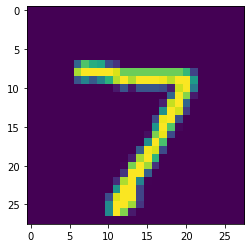

{0: 0.0, 1: 0.0, 2: 0.001, 3: 0.001, 4: 0.0, 5: 0.0, 6: 0.0, 7: 0.998, 8: 0.0, 9: 0.0}


In [7]:
plt.imshow(img)
predicted = client.predict(
    data_input={'input_layer': np.expand_dims(img, axis=0)}
)
plt.show()
print(dict(zip(np.arange(10), predicted[0].round(3))))
    
server.stop()

### Example 2: Multiple input nodes 

A sample YAML serving a TensorFlow Graph model with multiple input nodes.

```yaml 
steps:
  tensorflow_step:
    type: TENSORFLOW
    model_loading_path: bert_mrpc_frozen.pb
    input_names:
      - IteratorGetNext:0
      - IteratorGetNext:1
      - IteratorGetNext:4
    output_names:
      - loss/Softmax
    input_data_types:
      IteratorGetNext:0: INT32
      IteratorGetNext:1: INT32
      IteratorGetNext:4: INT32
    parallel_inference_config:
      workers: 1
```

In [8]:
konduit_yaml_path = "../yaml/tensorflow-bert.yaml"
server = server_from_file(konduit_yaml_path)
client = client_from_file(konduit_yaml_path)

data_input = {
    'IteratorGetNext:0': np.expand_dims(np.load('../data/bert/input-0.npy'), axis=0),
    'IteratorGetNext:1': np.expand_dims(np.load('../data/bert/input-1.npy'), axis=0),
    'IteratorGetNext:4': np.expand_dims(np.load('../data/bert/input-4.npy'), axis=0)
}

print(client.predict(data_input))
server.stop()

Starting server.........................

Server has started successfully.
[[9.9858320e-01 1.4168088e-03]
 [8.8414288e-04 9.9911588e-01]
 [9.9859291e-01 1.4070126e-03]
 [9.9752253e-01 2.4774617e-03]]


## Keras 

Konduit Serving supports Keras HDF5 models via Deeplearning4J model import. The following is a sample YAML file for serving a Keras model: 

- `type`: specify this as `KERAS`
- `model_loading_path`: location of the model weights 
- `input_names`, `output_names`: names for the input and output nodes, as lists  

Input and output names can be obtained by visualizing the graph in [Netron](https://github.com/lutzroeder/netron). 

```yaml
steps:
  keras_step:
    type: KERAS
    model_loading_path: ../data/keras/embedding_lstm_tensorflow_2.h5
    input_names:
    - input 
    output_names:
    - lstm_1

```

This YAML can be served using the `konduit.load` module: 

In [9]:
input_array = np.random.uniform(size = [10])
np.save("../data/keras/input.npy", input_array)
konduit_yaml_path = "../yaml/keras.yaml"
server = server_from_file(konduit_yaml_path)
client = client_from_file(konduit_yaml_path)
print(client.predict({"input": np.expand_dims(input_array, axis=0)}))

server.stop()

Starting server...

Server has started successfully.
[[[-3.53171281e-03 -6.55398145e-03 -9.07615386e-03 -1.11385630e-02
   -1.27962595e-02 -1.41087854e-02 -1.51341194e-02 -1.59251783e-02
   -1.65283810e-02 -1.69831831e-02]
  [-8.98816856e-04 -2.16921209e-03 -3.50447348e-03 -4.74313367e-03
   -5.81311202e-03 -6.69444632e-03 -7.39536854e-03 -7.93745089e-03
   -8.34691338e-03 -8.64967890e-03]
  [ 4.57964110e-04  7.27277948e-04  8.35937157e-04  8.26211413e-04
    7.38725299e-04  6.06592686e-04  4.54327965e-04  2.98691681e-04
    1.50312349e-04  1.51993027e-05]
  [-3.72108625e-04 -7.85349868e-04 -1.15279201e-03 -1.44809973e-03
   -1.67194800e-03 -1.83526019e-03 -1.95118226e-03 -2.03184737e-03
   -2.08712765e-03 -2.12461245e-03]
  [-1.70938822e-03 -2.67439662e-03 -3.14217363e-03 -3.29596084e-03
   -3.26494290e-03 -3.13617825e-03 -2.96555483e-03 -2.78691365e-03
   -2.61911890e-03 -2.47139740e-03]
  [ 4.90737101e-03  8.10048729e-03  1.01506319e-02  1.14426687e-02
    1.22359265e-02  1.27047608